In [1]:
import sys 

pathScripts = '../COMPAS/utils/CosmicIntegration' 

sys.path.append(pathScripts) 

In [40]:
import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib import rc
import astropy.units as u
from astropy import constants as const
from   astropy.cosmology import WMAP9 as cosmology
from scipy import stats
from   scipy.optimize import newton
import warnings
import time

import h5py as h5 

import ClassCOMPAS, ClassMSSFR, ClassCosmicIntegrator 
import FastCosmicIntegration as FCI 
import selection_effects

In [3]:
#Set latex environment for plots/labels
import matplotlib
matplotlib.rc('font', **{'family': 'serif'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams.update({'font.family':'serif'})


fl=22
fm=18
fs=16
import seaborn as sns
sns.set_style("white")

In [4]:
# this is just a little function that we will use to make the plot more beautiful (bigger ticks, labels)
# However, you do not have to use this (just uncommoment "layoutAxes" everywhere)
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = fm, second=False, labelpad=None, setMinor=True):
    matplotlib.rc('font', **{'family': 'serif'})

    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


In [7]:
bh_kick = 200
ns_kick = 500
sigma = 0.4

hobbs_pathData        = os.environ['SCRATCH']+f'/supernova_remnant_det/hobbs_combined.h5'
mm_pathData        = os.environ['WORK'] + f"/supernova_remnant_det/mullermandel_ns_{ns_kick}_sigma_{sigma}_det_combined.h5"

In [23]:
# First define the parameters

# For what DCO would you like the rate?  options: all, BHBH, BHNS, BNS
dco_type        = "BHNS"
# dco_type        = "BNS"

weight_column   = None
                        
merges_hubble_time     = True
pessimistic_CEE        = True
no_RLOF_after_CEE      = True

# Options for the redshift evolution 
max_redshift           = 10.0
max_redshift_detection = 2.0
redshift_step          = 0.001
z_first_SF             = 10

# Metallicity of the Universe
min_logZ               = -12.0 
max_logZ               = 0.0 
step_logZ              = 0.01

#and detector sensitivity
sensitivity            = "O1" 
snr_threshold          = 8 

Mc_max                 = 300.0 
Mc_step                = 0.1 
eta_max                = 0.25 
eta_step               = 0.01
snr_max                = 1000.0 
snr_step               = 0.1

# Parameters to calculate the representing SF mass (make sure these match YOUR simulation!)
m1_min          = 5 * u.Msun 
m1_max          = 150 * u.Msun
m2_min          = 0.1 * u.Msun
fbin            = 0.7

# Parameters determining dP/dZ and SFR(z), default options from Neijssel 2019
aSF             = 0.01 
bSF             = 2.77 
cSF             = 2.90 
dSF             = 4.70
#
mu0             = 0.035 
muz             = -0.23 
sigma0          = 0.39
sigmaz          = 0. 
alpha           = 0.0 

# Hobbs

In [24]:
hobbs_detection_rate, hobbs_formation_rate, hobbs_merger_rate, hobbs_redshifts, hobbs_COMPAS = FCI.find_detection_rate(
    hobbs_pathData, dco_type=dco_type, weight_column=weight_column,
    merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
    no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
    max_redshift_detection=max_redshift_detection,
    redshift_step=redshift_step, z_first_SF=z_first_SF,
    m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
    fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
    mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
    min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
    sensitivity=sensitivity, snr_threshold=snr_threshold,
    Mc_max=Mc_max, Mc_step=Mc_step,
    eta_max=eta_max, eta_step=eta_step,
    snr_max=snr_max, snr_step=snr_step)

/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  


Average_SF_mass_needed =  2954782463.1348767 solMass


In [25]:
hobbs_chirp_masses = (hobbs_COMPAS.mass1*hobbs_COMPAS.mass2)**(3./5.) / (hobbs_COMPAS.mass1 + hobbs_COMPAS.mass2)**(1./5.)

# sum things up across binaries
hobbs_total_formation_rate = np.sum(hobbs_formation_rate, axis=0)
hobbs_total_merger_rate = np.sum(hobbs_merger_rate, axis=0)
hobbs_total_detection_rate = np.sum(hobbs_detection_rate, axis=0)

# and across redshifts
hobbs_cumulative_detection_rate = np.cumsum(hobbs_total_detection_rate)
hobbs_detection_rate_by_binary = np.sum(hobbs_detection_rate, axis=1)

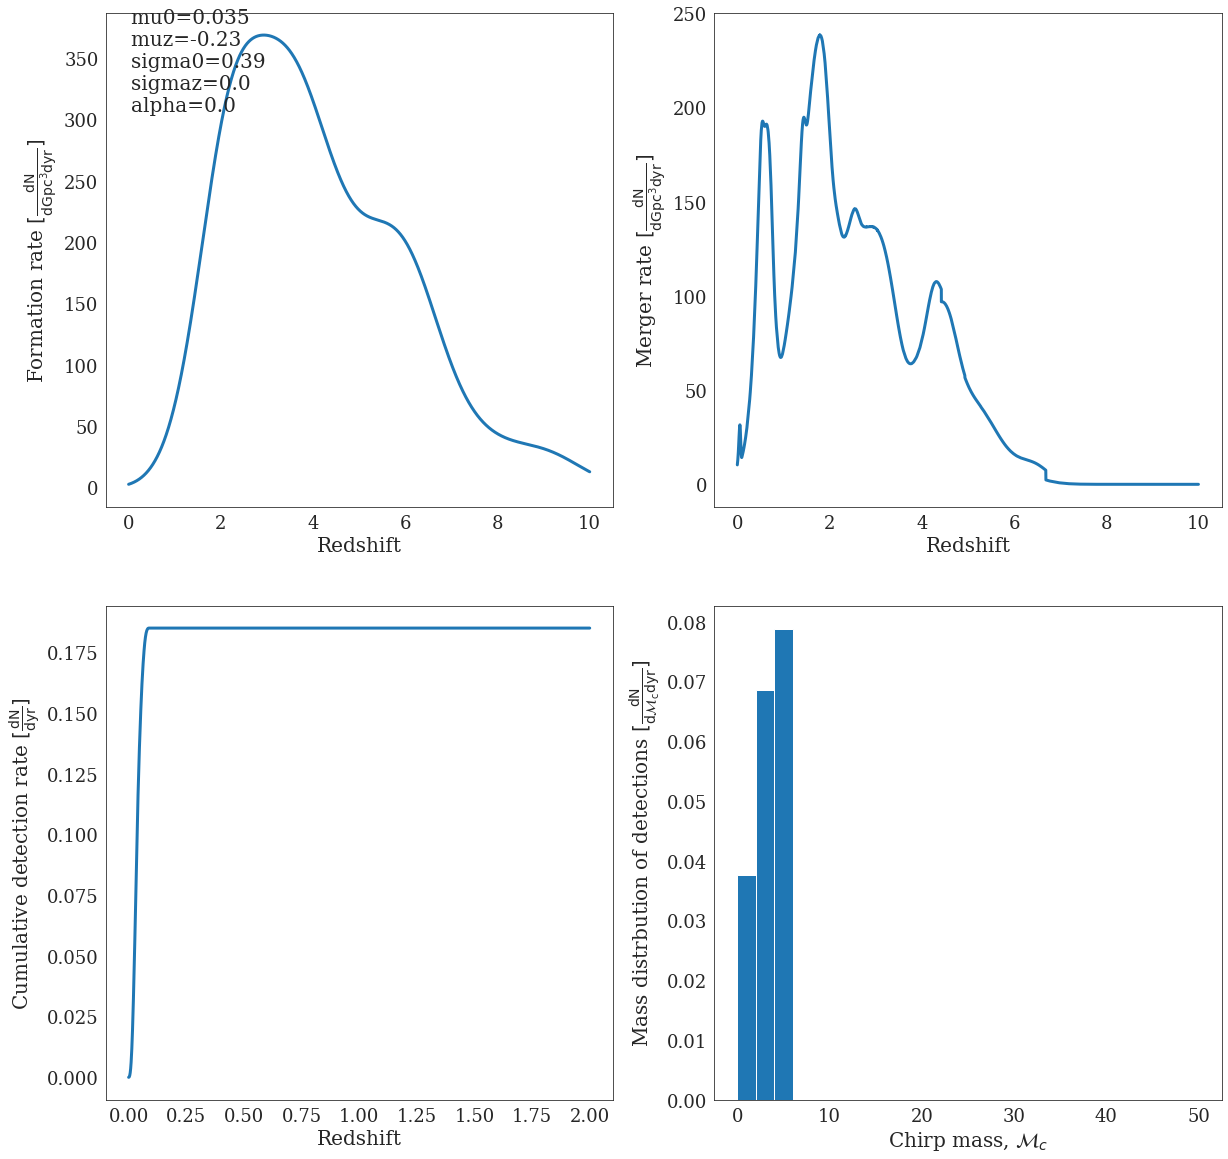

In [26]:
###########################
#Start plotting

# set some constants for the plots
plt.rc('font', family='serif')
fs = 20
lw = 3

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

axes[0,0].plot(hobbs_redshifts, hobbs_total_formation_rate, lw=lw)
axes[0,0].set_xlabel('Redshift', fontsize=fs)
axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

axes[0,1].plot(hobbs_redshifts, hobbs_total_merger_rate, lw=lw)
axes[0,1].set_xlabel('Redshift', fontsize=fs)
axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

axes[1,0].plot(hobbs_redshifts[:len(hobbs_cumulative_detection_rate)], hobbs_cumulative_detection_rate, lw=lw)
axes[1,0].set_xlabel('Redshift', fontsize=fs)
axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

axes[1,1].hist(hobbs_chirp_masses, weights=hobbs_detection_rate_by_binary, bins=25, range=(0, 50))
axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

#########################
#Plotvalues

# Add text upper left corner
axes[0,0].text(0.05,0.8, 
        "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
        transform=axes[0,0].transAxes, size = fs) 

for ax in axes.flatten():
    ax.tick_params(labelsize=0.9*fs)

# Save and show :)
# plt.savefig(imageDir + "RateInfoHist_mu0{}_muz{}_alpha{}_sigma0{}_sigmaz{}.png".format(mu0, muz, alpha, sigma0, sigmaz), bbox_inches='tight') 


In [27]:
hobbs_total_merger_rate

array([10.31058747, 10.52227239, 10.73146435, ...,  0.        ,
        0.        ,  0.        ])

# MullerMandel

In [33]:
mm_detection_rate, mm_formation_rate, mm_merger_rate, mm_redshifts, mm_COMPAS = FCI.find_detection_rate(
    mm_pathData, dco_type=dco_type, weight_column=weight_column,
    merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
    no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
    max_redshift_detection=max_redshift_detection,
    redshift_step=redshift_step, z_first_SF=z_first_SF,
    m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
    fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
    mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
    min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
    sensitivity=sensitivity, snr_threshold=snr_threshold,
    Mc_max=Mc_max, Mc_step=Mc_step,
    eta_max=eta_max, eta_step=eta_step,
    snr_max=snr_max, snr_step=snr_step)


/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  


Average_SF_mass_needed =  1017276535.5167899 solMass


In [34]:
mm_chirp_masses = (mm_COMPAS.mass1*mm_COMPAS.mass2)**(3./5.) / (mm_COMPAS.mass1 + mm_COMPAS.mass2)**(1./5.)

# sum things up across binaries
mm_total_formation_rate = np.sum(mm_formation_rate, axis=0)
mm_total_merger_rate = np.sum(mm_merger_rate, axis=0)
mm_total_detection_rate = np.sum(mm_detection_rate, axis=0)

# and across redshifts
mm_cumulative_detection_rate = np.cumsum(mm_total_detection_rate)
mm_detection_rate_by_binary = np.sum(mm_detection_rate, axis=1)

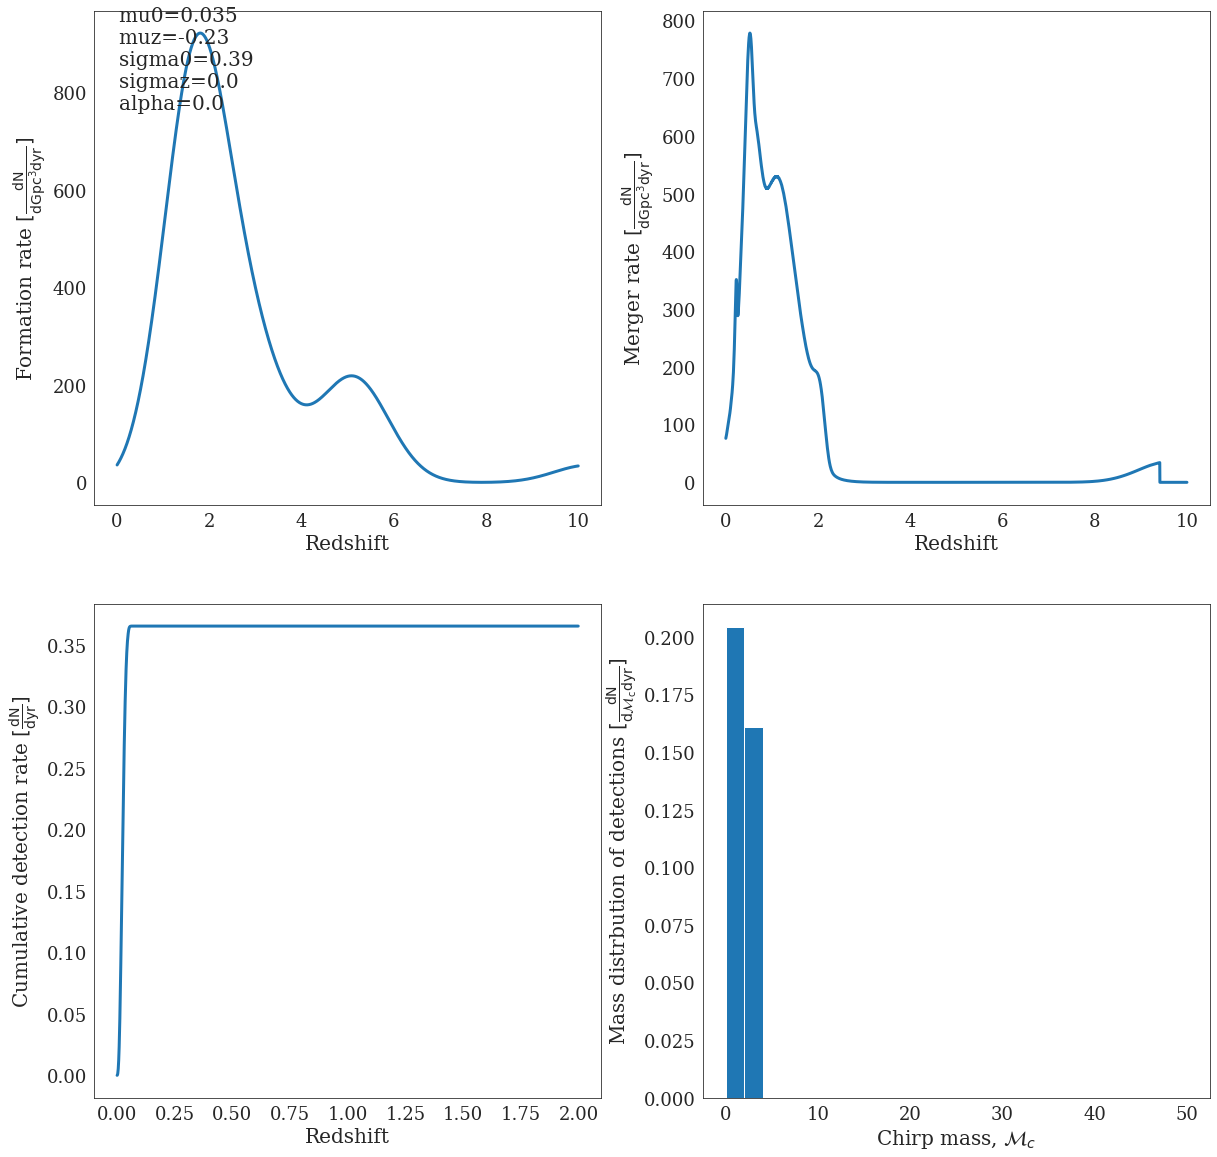

In [35]:
###########################
#Start plotting

# set some constants for the plots
plt.rc('font', family='serif')
fs = 20
lw = 3

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

axes[0,0].plot(mm_redshifts, mm_total_formation_rate, lw=lw)
axes[0,0].set_xlabel('Redshift', fontsize=fs)
axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

axes[0,1].plot(mm_redshifts, mm_total_merger_rate, lw=lw)
axes[0,1].set_xlabel('Redshift', fontsize=fs)
axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

axes[1,0].plot(mm_redshifts[:len(mm_cumulative_detection_rate)], mm_cumulative_detection_rate, lw=lw)
axes[1,0].set_xlabel('Redshift', fontsize=fs)
axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

axes[1,1].hist(mm_chirp_masses, weights=mm_detection_rate_by_binary, bins=25, range=(0, 50))
axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

#########################
#Plotvalues

# Add text upper left corner
axes[0,0].text(0.05,0.8, 
        "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
        transform=axes[0,0].transAxes, size = fs) 

for ax in axes.flatten():
    ax.tick_params(labelsize=0.9*fs)

# Save and show :)
# plt.savefig(imageDir + "RateInfoHist_mu0{}_muz{}_alpha{}_sigma0{}_sigmaz{}.png".format(mu0, muz, alpha, sigma0, sigmaz), bbox_inches='tight') 
            

# Some Useful Info

In [36]:
print(f"Hobbs Local {dco_type} Merger Rate: {hobbs_total_merger_rate[0]:.2f} / yr/ cubic Gpc")
print(f"MULLERMANDEL Local {dco_type} Merger Rate: {mm_total_merger_rate[0]:.2f} / yr / cubic Gpc")

Hobbs Local BHNS Merger Rate: 10.31 / yr/ cubic Gpc
MULLERMANDEL Local BHNS Merger Rate: 76.20 / yr / cubic Gpc


In [32]:
print("Number of", dco_type, "mergers in Hobbs :", len(hobbs_chirp_masses))
print("Number of", dco_type, "mergers in MULLERMANDEL:", len(mm_chirp_masses))

Number of BHNS mergers in Hobbs : 9168
Number of BHNS mergers in MULLERMANDEL: 4035


# Get error bars

In [114]:
# get error bars via bootstrapping

In [ ]:
# get error bars via repeated calculations

In [54]:
def get_merger_rates(pathData, n_samples, dco_type):
    merger_rates = np.zeros(n_samples)
    
    for i in range(n_samples):
        detection_rate, formation_rate, merger_rate, redshifts, COMPAS = FCI.find_detection_rate(
        pathData, dco_type=dco_type, weight_column=weight_column,
        merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
        no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
        max_redshift_detection=max_redshift_detection,
        redshift_step=redshift_step, z_first_SF=z_first_SF,
        m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
        fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
        mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
        min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
        sensitivity=sensitivity, snr_threshold=snr_threshold,
        Mc_max=Mc_max, Mc_step=Mc_step,
        eta_max=eta_max, eta_step=eta_step,
        snr_max=snr_max, snr_step=snr_step)

        total_merger_rate = np.sum(merger_rate, axis=0)

        merger_rates[i] = total_merger_rate[0]

    return merger_rates

## Get average Hobbs rates

In [58]:
n_samples = 10

In [59]:
# takes about 13s per sample
start = time.time()

hobbs_merger_rates_bhns = get_merger_rates(hobbs_pathData, n_samples, "BHNS")
    
end = time.time()
print(f"{n_samples} samples computed in {end-start:.2f} s")

/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)


Average_SF_mass_needed =  2953692401.0682726 solMass
Average_SF_mass_needed =  2957812209.7502065 solMass
Average_SF_mass_needed =  2965869081.158391 solMass
Average_SF_mass_needed =  2958198722.9062753 solMass
Average_SF_mass_needed =  2954340912.3438516 solMass
Average_SF_mass_needed =  2967958753.032338 solMass
Average_SF_mass_needed =  2965840491.170716 solMass
Average_SF_mass_needed =  2968532671.3978615 solMass
Average_SF_mass_needed =  2963326655.648069 solMass
Average_SF_mass_needed =  2956681988.5955563 solMass
10 samples computed in 129.30 s


In [60]:
# takes about 11s per sample
start = time.time()

hobbs_merger_rates_nsns = get_merger_rates(hobbs_pathData, n_samples, "BNS")
    
end = time.time()
print(f"{n_samples} samples computed in {end-start:.2f} s")

/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)


Average_SF_mass_needed =  2963337179.941629 solMass
Average_SF_mass_needed =  2952225316.419397 solMass
Average_SF_mass_needed =  2953561859.464194 solMass
Average_SF_mass_needed =  2963059990.9667635 solMass
Average_SF_mass_needed =  2981189353.4608316 solMass
Average_SF_mass_needed =  2966021330.2682724 solMass
Average_SF_mass_needed =  2970024867.7850943 solMass
Average_SF_mass_needed =  2957495289.843795 solMass
Average_SF_mass_needed =  2960405573.1114364 solMass
Average_SF_mass_needed =  2955873197.234023 solMass
10 samples computed in 109.24 s


In [74]:
mean = np.average(hobbs_merger_rates_bhns)
err = np.std(hobbs_merger_rates_bhns)
print(f"Hobbs Local BHNS Merger Rate: {mean:.2f} ± {err:.2f} / yr/ cubic Gpc")

Hobbs Local BHNS Merger Rate: 10.29 ± 0.02 / yr/ cubic Gpc


In [75]:
mean = np.average(hobbs_merger_rates_nsns)
err = np.std(hobbs_merger_rates_nsns)
print(f"Hobbs Local BNS Merger Rate: {mean:.2f} ± {err:.2f} / yr/ cubic Gpc")

Hobbs Local BNS Merger Rate: 3.00 ± 0.01 / yr/ cubic Gpc


## Get average Muller Mandel rates

In [63]:
# takes about 9s per sample
start = time.time()

mm_merger_rates_bhns = get_merger_rates(mm_pathData, n_samples, "BHNS")
    
end = time.time()
print(f"{n_samples} samples computed in {end-start:.2f} s")

/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)


Average_SF_mass_needed =  1019242174.9940555 solMass
Average_SF_mass_needed =  1018267582.611181 solMass
Average_SF_mass_needed =  1016907288.1405951 solMass
Average_SF_mass_needed =  1017529605.0405486 solMass
Average_SF_mass_needed =  1023154103.1812418 solMass
Average_SF_mass_needed =  1016746227.1795037 solMass
Average_SF_mass_needed =  1019519316.0553775 solMass
Average_SF_mass_needed =  1017255797.8421948 solMass
Average_SF_mass_needed =  1017088349.6466836 solMass
Average_SF_mass_needed =  1016681373.8243005 solMass
10 samples computed in 94.36 s


In [64]:
# takes about 7s per sample
start = time.time()

mm_merger_rates_nsns = get_merger_rates(mm_pathData, n_samples, "BNS")
    
end = time.time()
print(f"{n_samples} samples computed in {end-start:.2f} s")

/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)


Average_SF_mass_needed =  1020377761.5330654 solMass
Average_SF_mass_needed =  1016749733.3336251 solMass
Average_SF_mass_needed =  1018382877.7268585 solMass
Average_SF_mass_needed =  1018018205.9938439 solMass
Average_SF_mass_needed =  1016189984.2602179 solMass
Average_SF_mass_needed =  1017381239.8697917 solMass
Average_SF_mass_needed =  1017094647.9474308 solMass
Average_SF_mass_needed =  1018652564.1706017 solMass
Average_SF_mass_needed =  1012656445.9488524 solMass
Average_SF_mass_needed =  1019338298.4442934 solMass
10 samples computed in 67.39 s


In [71]:
mean = np.average(mm_merger_rates_bhns)
err = np.std(mm_merger_rates_bhns)
print(f"MULLERMANDEL Local BHNS Merger Rate: {mean:.2f} ± {err:.3f} / yr/ cubic Gpc")

MULLERMANDEL Local BHNS Merger Rate: 76.13 ± 0.141 / yr/ cubic Gpc


In [73]:
mean = np.average(mm_merger_rates_nsns)
err = np.std(mm_merger_rates_nsns)
print(f"MULLERMANDEL Local BNS Merger Rate: {mean:.2f} ± {err:.3f} / yr/ cubic Gpc")

MULLERMANDEL Local BNS Merger Rate: 2.14 ± 0.004 / yr/ cubic Gpc


# Period-Eccentricity Distribution

The H5 file contains ALL the DCOs. The COMPAS object only contains the DCOs that merge within hubble time AND are of type type_dco.

To get the eccentricity-period distribution of BNSs, we set dco_type='bns' above, and will select the set of DCOs from the H5 file whose Merges_Hubble_Time==True, Stellar_Type(1)'+ 'Stellar_Type(2)==26.

In [144]:
def mask_type(data, st_type1, st_type2, dco_type='BBH', merge=None):
    masked_data = data
    
    if merge is not None:
        mask_hubble = (merge==True)
        masked_data = masked_data[mask_hubble]
        st_type1 = st_type1[mask_hubble]
        st_type2 = st_type2[mask_hubble]
        
    if dco_type=='BBH':
        st_type_sum = 28
    if dco_type=='BNS':
        st_type_sum = 26
    if dco_type=='BHNS':
        st_type_sum = 27
    if dco_type=='all':
        return masked_data
    
    mask = (st_type1 + st_type2==st_type_sum)
    return masked_data[mask]

In [159]:
# sma in AU
# m1 in M_sun 
# m2 in M_sun
# period in yr

def sma_to_period(sma, m1, m2):
    sma = sma*u.au
    m1 = m1*const.M_sun
    m2 = m2*const.M_sun
    
    return 2*np.pi*np.sqrt((sma**3)/(const.G*(m1+m2))).to(u.yr).value

In [121]:
hobbs_fdata = h5.File(hobbs_pathData, 'r')
hobbs_merge = hobbs_fdata['BSE_Double_Compact_Objects']["Merges_Hubble_Time"][()]

hobbs_m1_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Mass(1)"][()]
hobbs_m2_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Mass(2)"][()]

hobbs_type1_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Stellar_Type(1)"][()]
hobbs_type2_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Stellar_Type(2)"][()]

hobbs_ecc_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Eccentricity@DCO"][()]
hobbs_sma_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["SemiMajorAxis@DCO"][()]

hobbs_fdata.close()

In [162]:
hobbs_ecc = mask_type(hobbs_ecc_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=hobbs_merge)
hobbs_sma = mask_type(hobbs_sma_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=hobbs_merge)

hobbs_m1 = mask_type(hobbs_m1_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=hobbs_merge)
hobbs_m2 = mask_type(hobbs_m2_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=hobbs_merge)

print(len(hobbs_ecc))

hobbs_period = sma_to_period(hobbs_sma, hobbs_m1, hobbs_m2)
print((hobbs_period))

4032
[0.000812   0.00296969 0.00131532 ... 0.00100404 0.00545101 0.00213735]


In [147]:
mm_fdata = h5.File(mm_pathData, 'r')
mm_merge = mm_fdata['BSE_Double_Compact_Objects']["Merges_Hubble_Time"][()]

mm_m1_ALL = mm_fdata['BSE_Double_Compact_Objects']["Mass(1)"][()]
mm_m2_ALL = mm_fdata['BSE_Double_Compact_Objects']["Mass(2)"][()]

mm_type1_ALL = mm_fdata['BSE_Double_Compact_Objects']["Stellar_Type(1)"][()]
mm_type2_ALL = mm_fdata['BSE_Double_Compact_Objects']["Stellar_Type(2)"][()]

mm_ecc_ALL = mm_fdata['BSE_Double_Compact_Objects']["Eccentricity@DCO"][()]
mm_sma_ALL = mm_fdata['BSE_Double_Compact_Objects']["SemiMajorAxis@DCO"][()]
mm_fdata.close()

In [163]:
mm_ecc = mask_type(mm_ecc_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=mm_merge)
mm_sma = mask_type(mm_sma_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=mm_merge)

mm_m1 = mask_type(mm_m1_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=mm_merge)
mm_m2 = mask_type(mm_m2_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=mm_merge)

print(len(mm_ecc))

mm_period = sma_to_period(mm_sma, mm_m1, mm_m2)
print((mm_period))

4035
[0.00034699 0.00597268 0.00306999 ... 0.00150121 0.00763563 0.00226793]


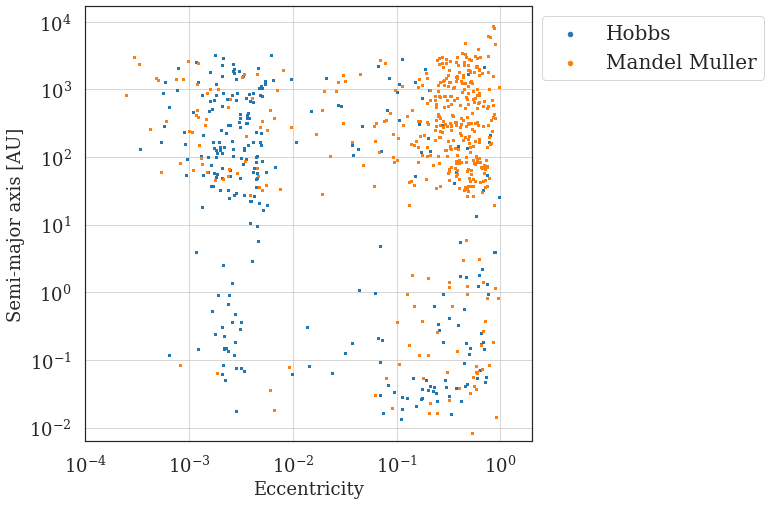

In [47]:
f, ax= plt.subplots(1, 1,  figsize=(8,8)) 

ms=1


layoutAxes(ax=ax, nameX='Eccentricity',\
           nameY='Semi-major axis [AU]')

plt.scatter(hobbs_ecc, hobbs_sma, s=ms, label='Hobbs')
plt.scatter(mm_ecc, mm_sma, s=ms, label='Mandel Muller')


lgnd = plt.legend(bbox_to_anchor=(1, 1), scatterpoints=1, fontsize=fs)
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[1]._sizes = [20]
    
plt.loglog()
plt.xlim(1e-4, 2e0)
plt.grid()
plt.show()


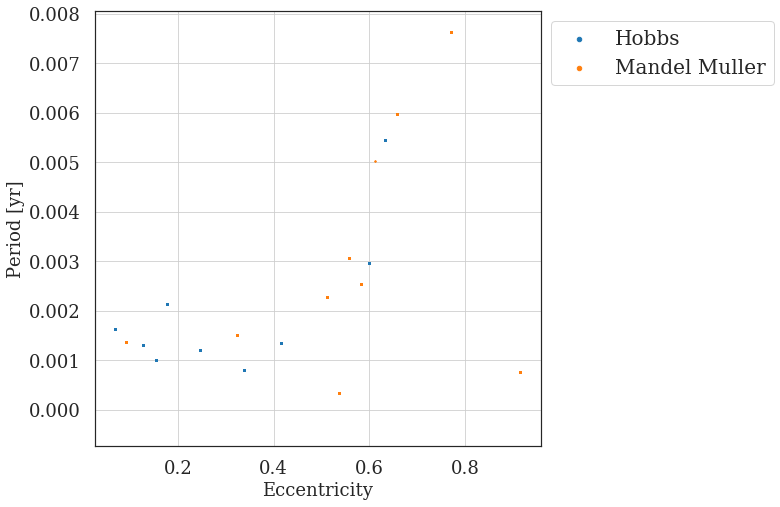

In [166]:
f, ax= plt.subplots(1, 1,  figsize=(8,8)) 

ms=1


layoutAxes(ax=ax, nameX='Eccentricity',\
           nameY='Period [yr]')

plt.scatter(hobbs_ecc, hobbs_period, s=ms, label='Hobbs')
plt.scatter(mm_ecc, mm_period, s=ms, label='Mandel Muller')


lgnd = plt.legend(bbox_to_anchor=(1, 1), scatterpoints=1, fontsize=fs)
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[1]._sizes = [20]
    
# plt.loglog()
# plt.xlim(1e-4, 2e0)
plt.grid()
plt.show()